In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

DATA_PATH = r"C:\Users\91843\Desktop\Clouside\Inventory_forecast\dataset\top_10_sales_data.csv"

# Load dataset
df = pd.read_csv(DATA_PATH, parse_dates=["sales_date"])

PRODUCT_IDS = [4, 8]

for product_id in PRODUCT_IDS:
    print(f" SARIMAX WITH LAGS – Product {product_id}")

    # Filter product
    product_df = df[df["product_id"] == product_id]

    # Force usage if empty
    if product_df.empty:
        product_df = df.copy()

    # Sort by date
    product_df = product_df.sort_values("sales_date")

    product_df["lag_1"] = product_df["quantity"].shift(1)
    product_df["lag_7"] = product_df["quantity"].shift(7)

    # Drop initial NaNs created by lagging
    product_df = product_df.dropna()

    y = product_df["quantity"].values
    X = product_df[["lag_1", "lag_7"]].values

    split_idx = int(len(y) * 0.8)
    y_train, y_test = y[:split_idx], y[split_idx:]
    X_train, X_test = X[:split_idx], X[split_idx:]

    model = SARIMAX(
        y_train,
        exog=X_train,
        order=(1, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    model_fit = model.fit(disp=False)

    preds = model_fit.predict(
        start=len(y_train),
        end=len(y) - 1,
        exog=X_test
    )

    mape = np.mean(
        np.abs((y_test - preds) / np.where(y_test == 0, 1, y_test))
    ) * 100

    print(f"MAPE: {mape:.2f}%")


 SARIMAX WITH LAGS – Product 4
MAPE: 90.86%
 SARIMAX WITH LAGS – Product 8
MAPE: 90.86%


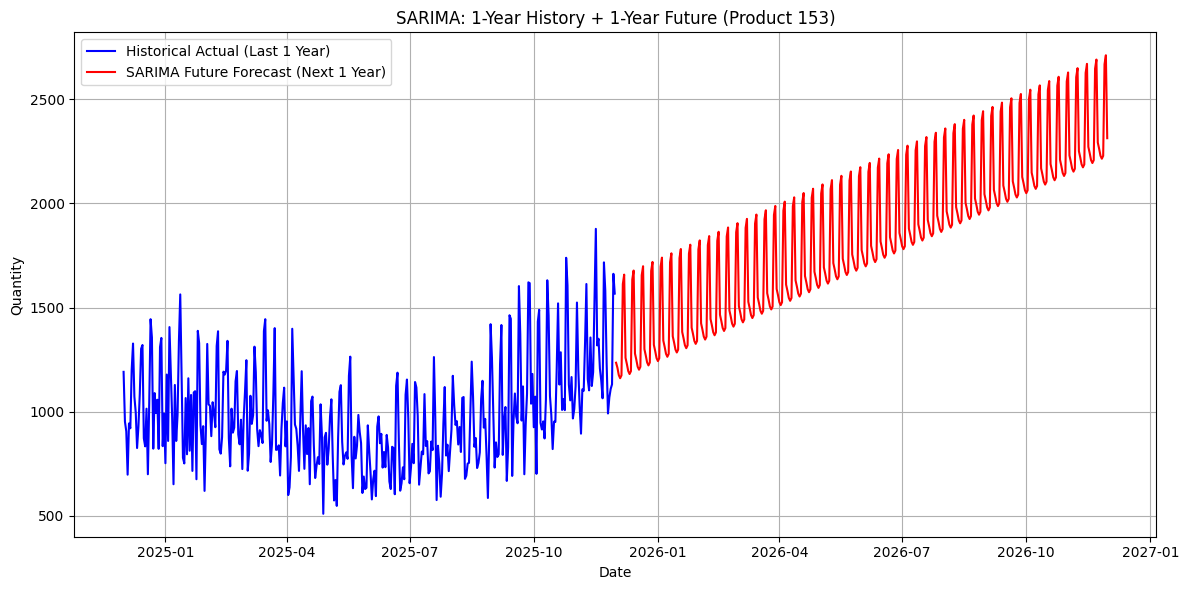

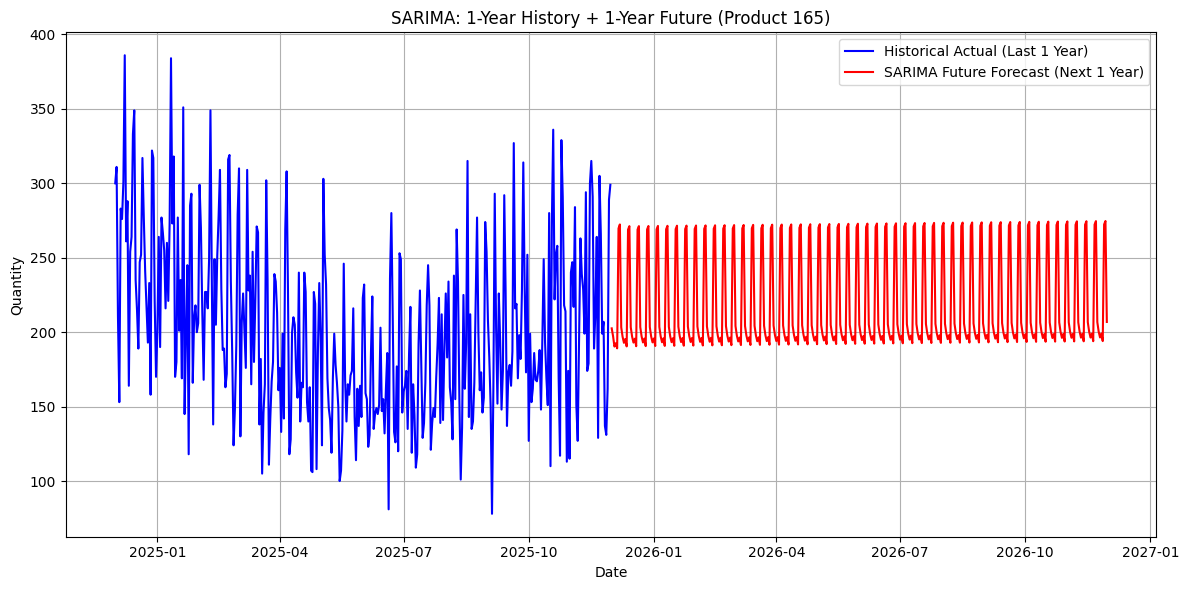

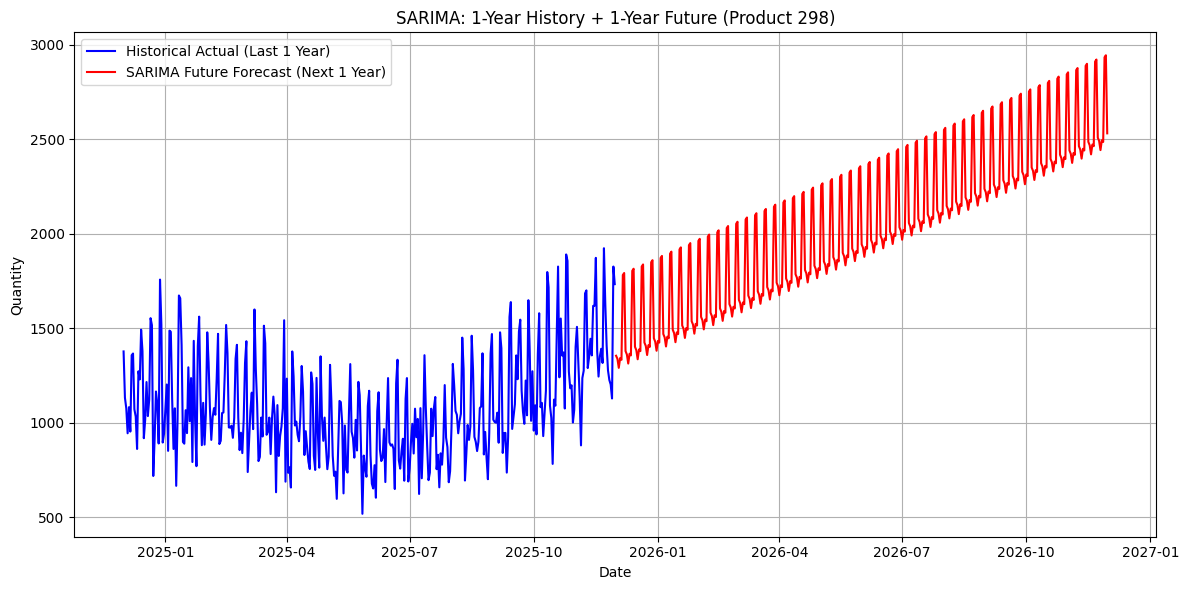

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

DATA_PATH = r"C:\Users\91843\Desktop\Clouside\Inventory_forecast\dataset\top_10_sales_data.csv"
PRODUCT_IDS = [153, 165, 298]   
HISTORY_DAYS = 365
FUTURE_DAYS = 365

df = pd.read_csv(DATA_PATH, parse_dates=["sales_date"])

# DAILY AGGREGATION
df_daily = (
    df.groupby(["product_id", "sales_date"], as_index=False)
      .agg({"quantity": "sum"})
)

for product_id in PRODUCT_IDS:
    product_df = (
        df_daily[df_daily["product_id"] == product_id]
        .sort_values("sales_date")
    )

    # Take last 1 year of history
    product_df_hist = product_df.tail(HISTORY_DAYS)

    y = product_df["quantity"].values
    dates = product_df["sales_date"]

    model = SARIMAX(
        y,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    forecast = model_fit.forecast(steps=FUTURE_DAYS)

    last_date = dates.iloc[-1]
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=FUTURE_DAYS,
        freq="D"
    )

    plt.figure(figsize=(12, 6))

    plt.plot(
        product_df_hist["sales_date"],
        product_df_hist["quantity"],
        label="Historical Actual (Last 1 Year)",
        color="blue"
    )

    plt.plot(
        future_dates,
        forecast,
        label="SARIMA Future Forecast (Next 1 Year)",
        color="red"
    )

    plt.title(f"SARIMA: 1-Year History + 1-Year Future (Product {product_id})")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


16:07:14 - cmdstanpy - INFO - Chain [1] start processing
16:07:14 - cmdstanpy - INFO - Chain [1] done processing


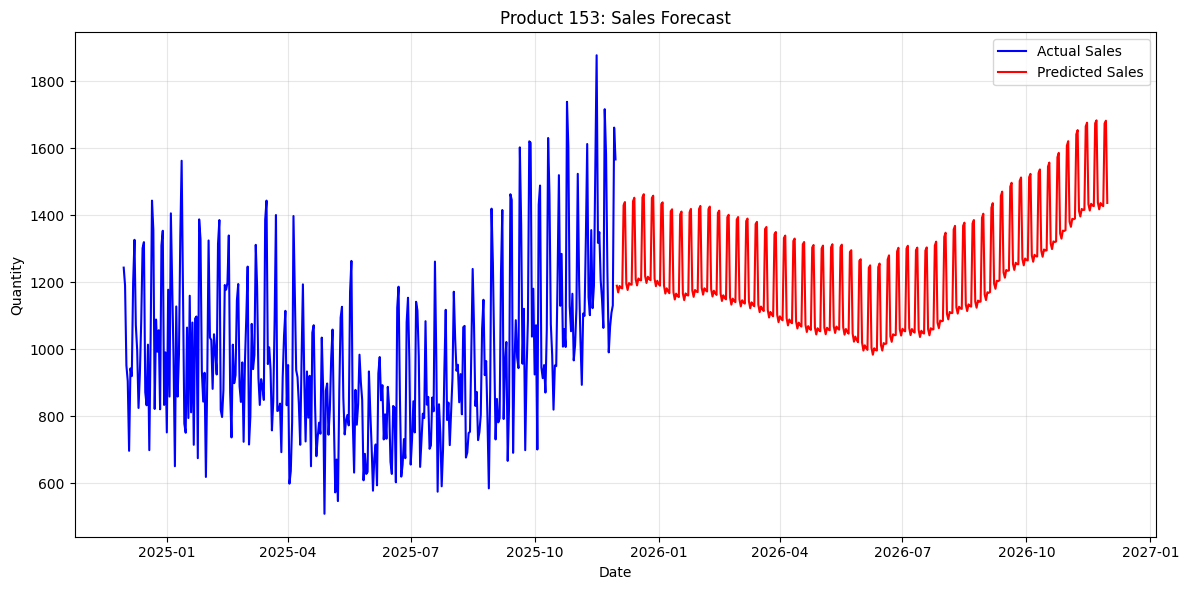

16:07:15 - cmdstanpy - INFO - Chain [1] start processing
16:07:15 - cmdstanpy - INFO - Chain [1] done processing


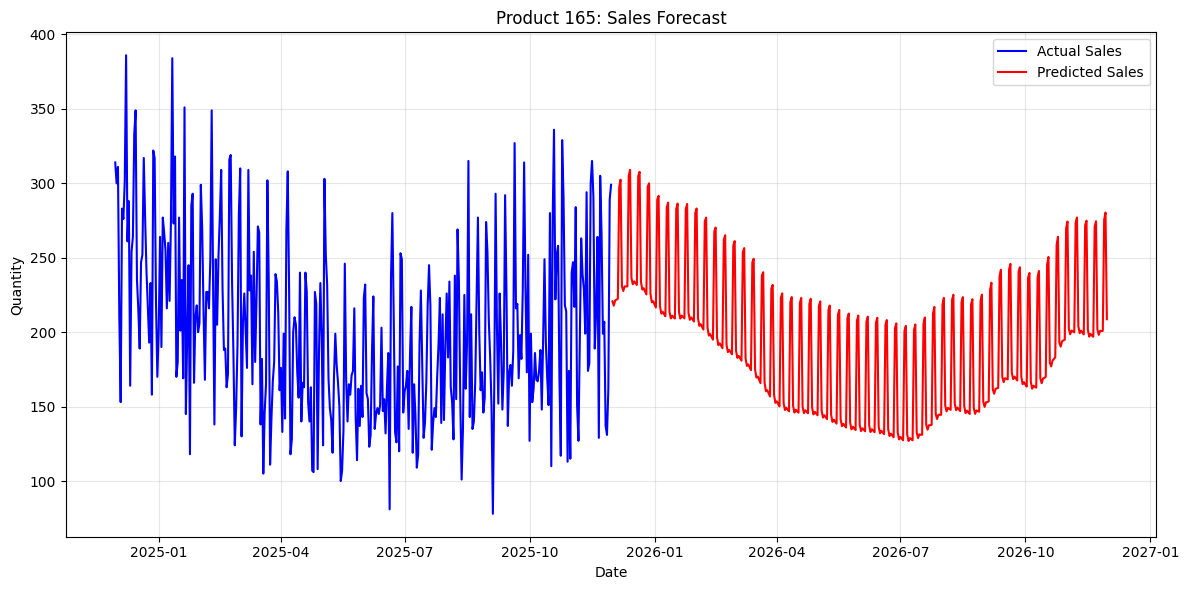

16:07:16 - cmdstanpy - INFO - Chain [1] start processing
16:07:16 - cmdstanpy - INFO - Chain [1] done processing


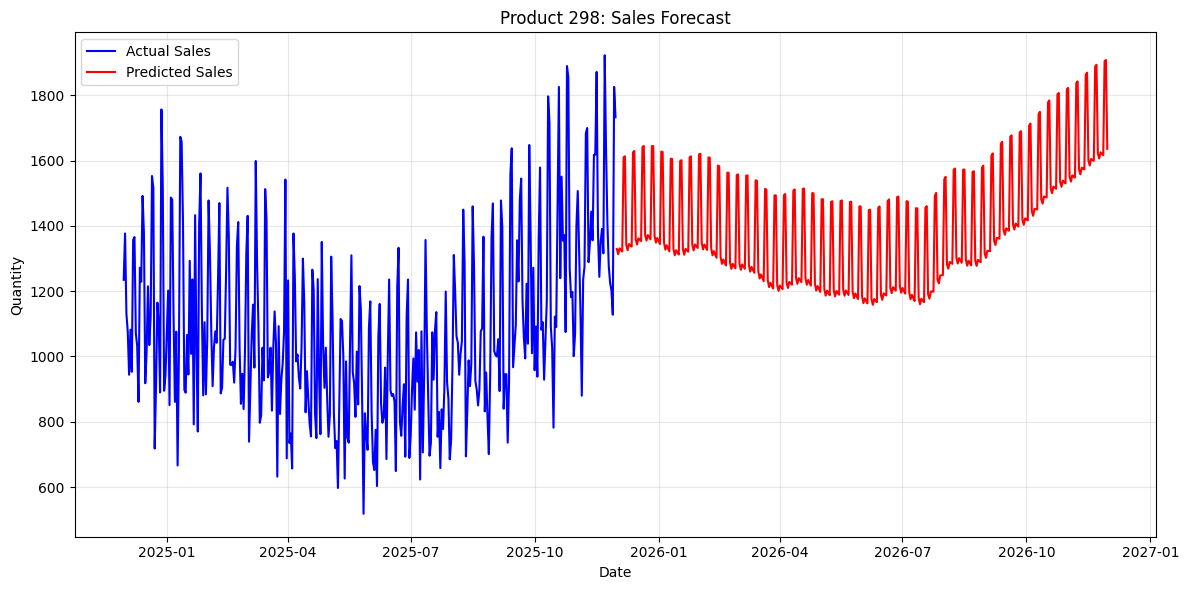

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet


DATA_PATH = r"C:\Users\91843\Desktop\Clouside\Inventory_forecast\dataset\top_10_sales_data.csv"
PRODUCT_IDS = [153, 165, 298] 
HISTORY_DAYS = 365
FUTURE_DAYS = 365

df = pd.read_csv(DATA_PATH, parse_dates=["sales_date"])

df_daily = df.groupby(["product_id", "sales_date"], as_index=False).agg({"quantity": "sum"})

for product_id in PRODUCT_IDS:
   
    product_df = df_daily[df_daily["product_id"] == product_id].copy()
    
    if len(product_df) < 2:
        continue

    product_df = product_df.set_index("sales_date")
    full_range = pd.date_range(start=product_df.index.min(), end=product_df.index.max(), freq='D')
    product_df = product_df.reindex(full_range).fillna(0).reset_index()
    product_df.columns = ["ds", "product_id", "y"]
    
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(product_df[["ds", "y"]])

    future = model.make_future_dataframe(periods=FUTURE_DAYS)
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0) # No negative sales

    plt.figure(figsize=(12, 6))

    hist_start = product_df["ds"].max() - pd.Timedelta(days=HISTORY_DAYS)
    df_hist_plot = product_df[product_df["ds"] >= hist_start]
    plt.plot(df_hist_plot["ds"], df_hist_plot["y"], label="Actual Sales", color="blue")

    future_forecast = forecast[forecast['ds'] > product_df["ds"].max()]
    plt.plot(future_forecast["ds"], future_forecast["yhat"], label="Predicted Sales", color="red")

    plt.title(f"Product {product_id}: Sales Forecast")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()